<a href="https://www.kaggle.com/code/rishikumar15/predict-diabetic-retinopathy?scriptVersionId=214105731" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#  1. Predict Diabetic Retinopathy
## 2. Class activation heatmap for image classification
## 3. Grad-CAM class activation visualization



# Table of contents

[<h3>1. Load and transform the dataset</h3>](#1)

[<h3>2. Load the Images with a generator</h3>](#2)

[<h3>3. Test 7 canned architectures with pre-trained weights</h3>](#3)

[<h3>4. Train the model MobileNetV2</h3>](#4)

[<h3>5. Visualize the result</h3>](#5)

[<h3>6. Class activation heatmap for image classification</h3>](#6)

[<h3>7. Using a two-class model (DR and No_DR)</h3>](#7)

## About the Data
The five directories with the respective images:

- 0 - No_DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferate_DR

The dataset contains an export.pkl file which is a ResNet34 model trained on the dataset for 20 epochs using the FastAI library.


# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    
    display(Markdown(string))

In [2]:
image_dir = Path('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [3]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

Filepath     Label
0  ../input/diabetic-retinopathy-224x224-gaussian...  Moderate
1  ../input/diabetic-retinopathy-224x224-gaussian...  Moderate
2  ../input/diabetic-retinopathy-224x224-gaussian...     No_DR
3  ../input/diabetic-retinopathy-224x224-gaussian...     No_DR
4  ../input/diabetic-retinopathy-224x224-gaussian...     No_DR

## Visualization

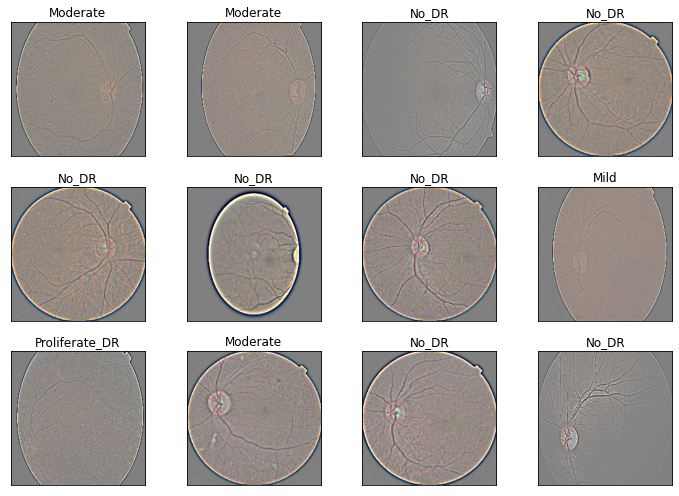

In [4]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

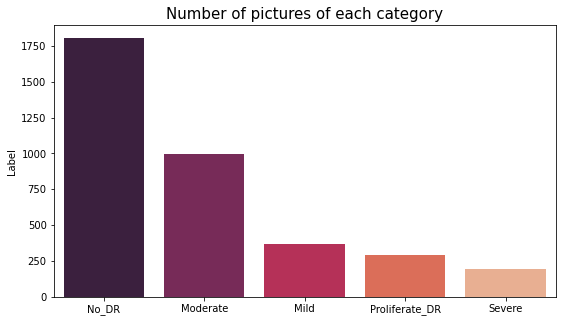

In [5]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# 2. Load the Images with a generator<a class="anchor" id="2"></a>

In [6]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

# 3. Test 7 canned architectures with pre-trained weights<a class="anchor" id="3"></a>



In [7]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [8]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [9]:
# Dictionary with the models
# models = {
#      "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
#       "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
#      "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
#      "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
#      "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
#      "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
#      "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
#      "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
#      "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
#      "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
#      "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
#      "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
#      "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
#      "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
#     "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
#     "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
#     "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
#     "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
#     "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
#     "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
#     "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
#     "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
#     "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
#     "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
#     "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
#     "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
#     "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
#     "Xception": {"model":tf.keras.applications.Xception, "perf":0}
# }
models = {
      "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


93/93 [==============================] - 27s 231ms/step - loss: 0.9180 - accuracy: 0.6657 - val_loss: 0.6578 - val_accuracy: 0.7690
MobileNetV2          trained in 27.7 sec
93/93 [==============================] - 13s 120ms/step - loss: 0.9945 - accuracy: 0.6454 - val_loss: 0.6401 - val_accuracy: 0.7872
MobileNet            trained in 12.83 sec
93/93 [==============================] - 15s 128ms/step - loss: 1.2228 - accuracy: 0.5226 - val_loss: 0.9872 - val_accuracy: 0.6535
MobileNetV3Large     trained in 15.45 sec
93/93 [==============================] - 14s 120ms/step - loss: 1.3439 - accuracy: 0.4848 - val_loss: 1.1498 - val_accuracy: 0.5289
MobileNetV3Small     trained in 14.31 sec
93/93 [==============================] - 16s 137ms/step - loss: 1.0855 - accuracy: 0.5851 - val_loss: 0.8407 - val_accurac

In [10]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

model  train_accuracy  val_accuracy  Training time (sec)
0         MobileNet          0.7070        0.7872                12.83
1       MobileNetV2          0.7239        0.7690                27.70
2             VGG16          0.6369        0.7295                17.35
3             VGG19          0.6342        0.7173                17.93
4          ResNet50          0.6362        0.6930                16.00
5  MobileNetV3Large          0.5509        0.6535                15.45
6  MobileNetV3Small          0.4845        0.5289                14.31

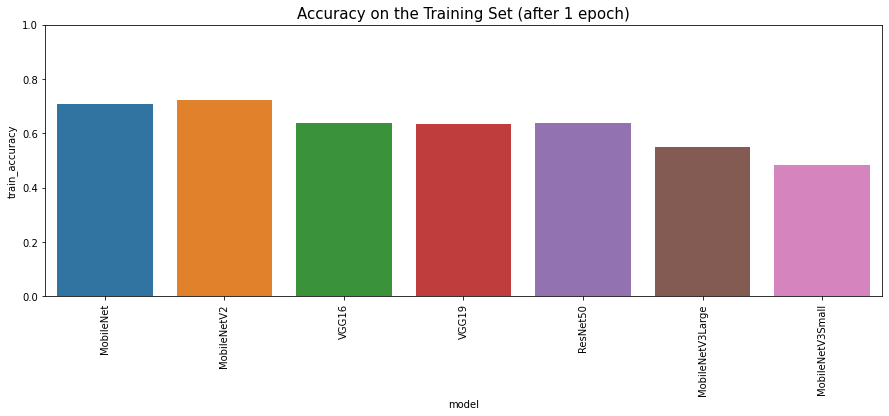

In [11]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

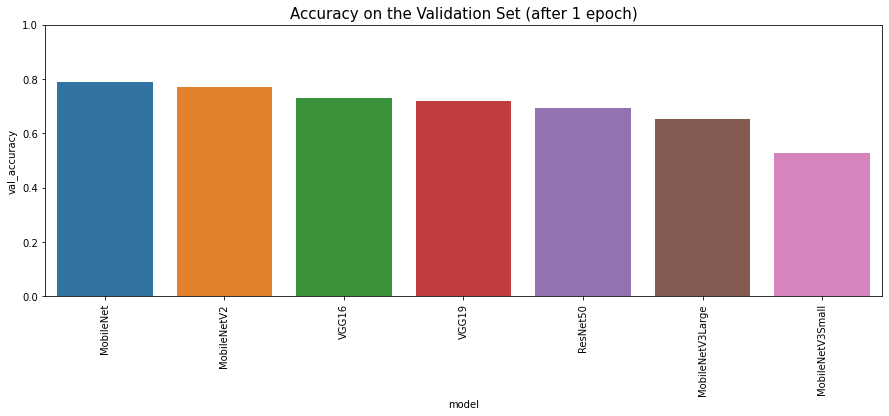

In [12]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the Validation Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

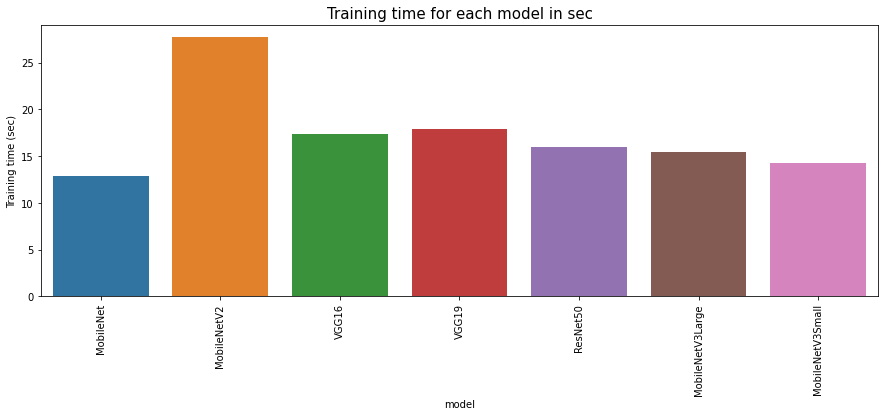

In [13]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 4. Train the model MobileNetV2<a class="anchor" id="4"></a>

In [14]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False




In [15]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
93/93 [==============================] - 13s 113ms/step - loss: 1.0155 - accuracy: 0.6240 - val_loss: 0.6642 - val_accuracy: 0.7477
Epoch 2/10
93/93 [==============================] - 10s 109ms/step - loss: 0.6439 - accuracy: 0.7631 - val_loss: 0.6315 - val_accuracy: 0.7903
Epoch 3/10
93/93 [==============================] - 10s 106ms/step - loss: 0.5803 - accuracy: 0.7827 - val_loss: 0.5699 - val_accuracy: 0.7964
Epoch 4/10
93/93 [==============================] - 10s 104ms/step - loss: 0.5645 - accuracy: 0.7932 - val_loss: 0.6275 - val_accuracy: 0.7690
Epoch 5/10
93/93 [==============================] - 10s 105ms/step - loss: 0.5391 - accuracy: 0.7912 - val_loss: 0.6264 - val_accuracy: 0.7660


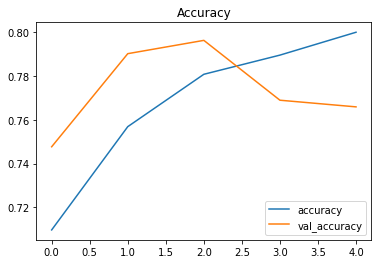

In [16]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

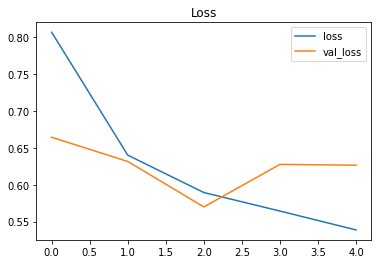

In [17]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 5. Visualize the result<a class="anchor" id="5"></a>

In [18]:
results = model.evaluate(test_images, verbose=0)

In [19]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.56258

## Accuracy on the test set: 80.11%

In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Moderate', 'Moderate', 'No_DR', 'Moderate', 'No_DR']


In [21]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

          Mild       0.53      0.61      0.57        31
      Moderate       0.67      0.82      0.73       103
         No_DR       0.93      0.99      0.96       190
Proliferate_DR       1.00      0.04      0.07        27
        Severe       1.00      0.06      0.12        16

      accuracy                           0.80       367
     macro avg       0.83      0.50      0.49       367
  weighted avg       0.83      0.80      0.76       367



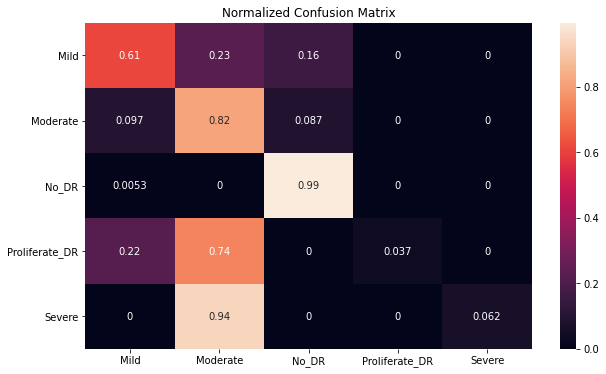

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

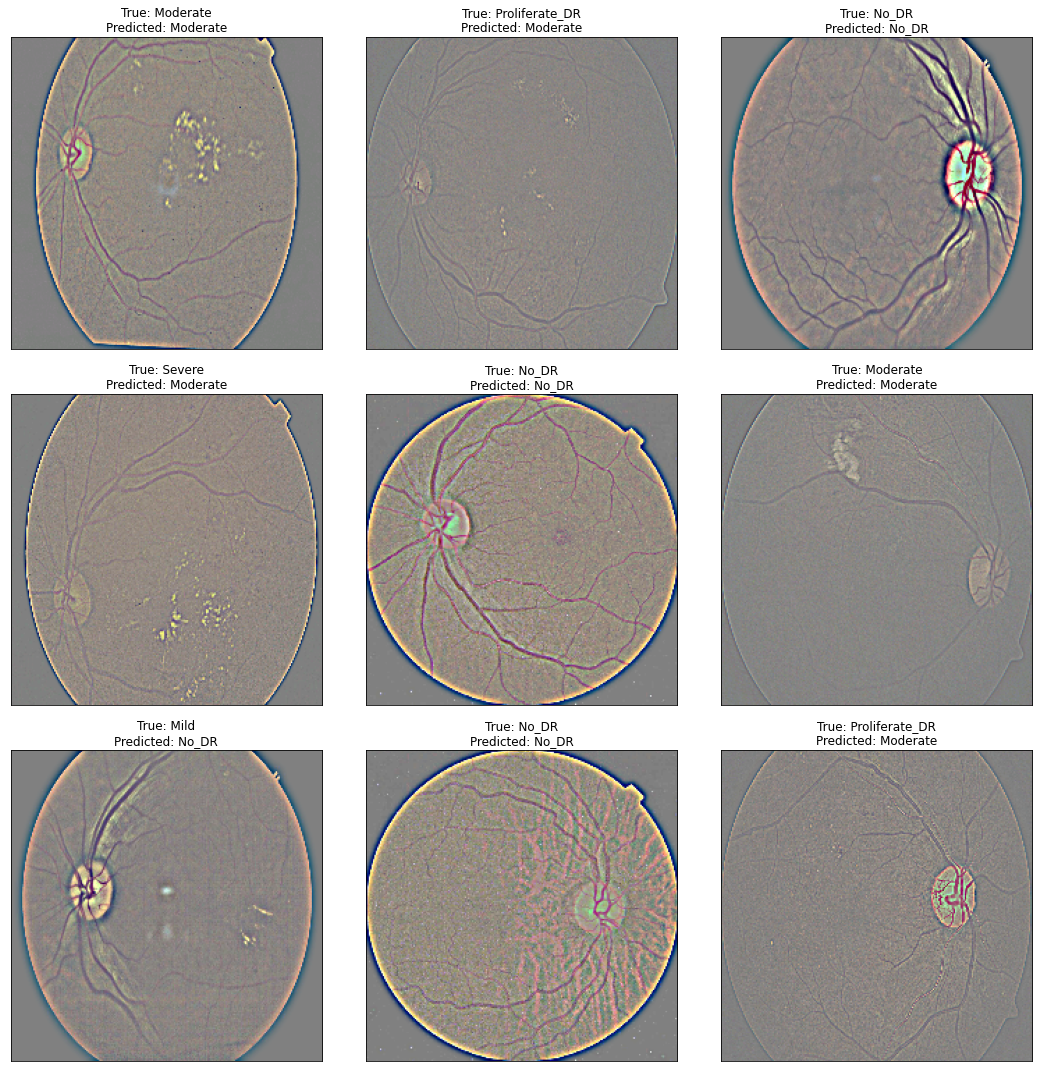

In [23]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

# 6. Class activation heatmap for image classification<a class="anchor" id="6"></a>
## Grad-CAM class activation visualization
*Code adapted from keras.io*

In [24]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].activation = None

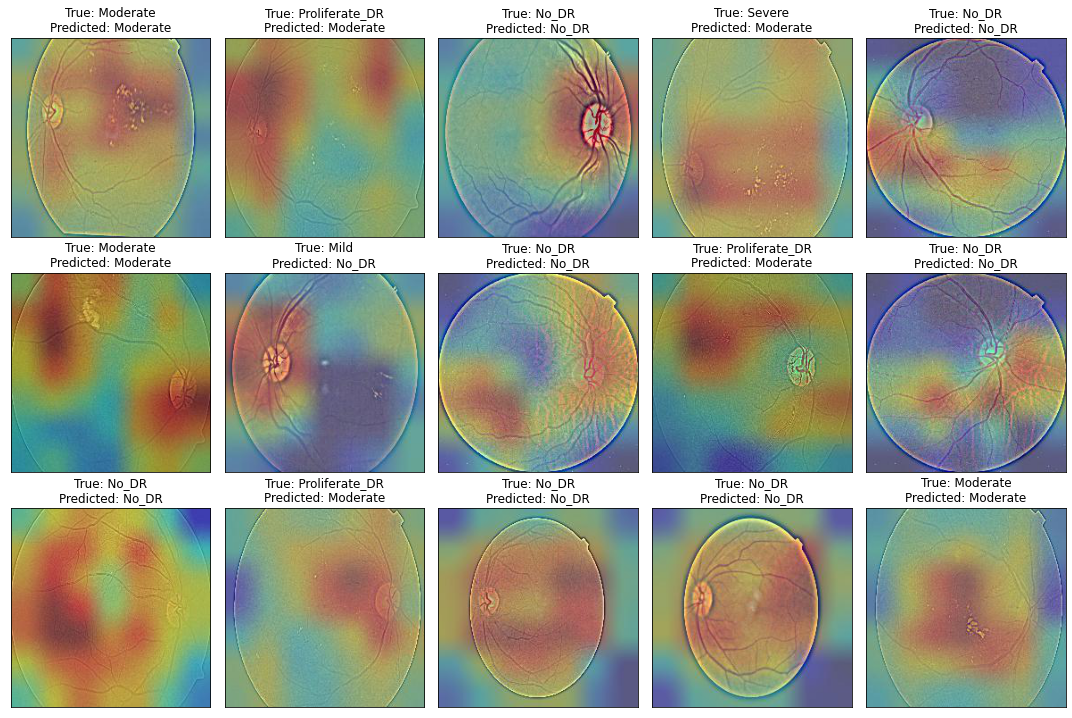

In [25]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

Here we saw in most cases the model is giving accurate solutions to the Images and cases where there spectrum with mild and moderate have an some accuracies issue.

# 7. Using a two-class model (DR and No_DR)<a class="anchor" id="7"></a>

As we have seen before, the prediction are very accurate to predict if someone has Diabetic Retinopathy or not. Nevertheless, it is not good at predicting the intensity of Diabetic Retinopathy when it is present. Maybe because it is subjective to the doctor to rate the intensity degree and different doctors don't have the same way to evaluate them. Maybe there are other factors taken in consideration to evaluate the intensity, which are independent from the pictures. As this point, without knowing more about the data, we can only speculate.

In this chapter, we'll reduce the label to a two-class model, because we can imagine that the most important part of this analysis is to find out if someone has Diabetic Retinopathy or not.

In [26]:
# Map the labels to have only "No_DR" and "DR"
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x == 'No_DR' else 'DR')
image_df_red.head(25)

Filepath  Label
0   ../input/diabetic-retinopathy-224x224-gaussian...     DR
1   ../input/diabetic-retinopathy-224x224-gaussian...     DR
2   ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
3   ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
4   ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
5   ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
6   ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
7   ../input/diabetic-retinopathy-224x224-gaussian...     DR
8   ../input/diabetic-retinopathy-224x224-gaussian...     DR
9   ../input/diabetic-retinopathy-224x224-gaussian...     DR
10  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
11  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
12  ../input/diabetic-retinopathy-224x224-gaussian...     DR
13  ../input/diabetic-retinopathy-224x224-gaussian...     DR
14  ../input/diabetic-retinopathy-224x224-gaussian...     DR
15  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
16  ../input/diabetic-retinopathy-224x224-gaussian...     DR
17  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
18  ../input/diabetic-retinopathy-224x224-gaussian...     DR
19  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
20  ../input/diabetic-retinopathy-224x224-gaussian...     DR
21  ../input/diabetic-retinopathy-224x224-gaussian...     DR
22  ../input/diabetic-retinopathy-224x224-gaussian...  No_DR
23  ../input/diabetic-retinopathy-224x224-gaussian...     DR
24  ../input/diabetic-retinopathy-224x224-gaussian...     DR

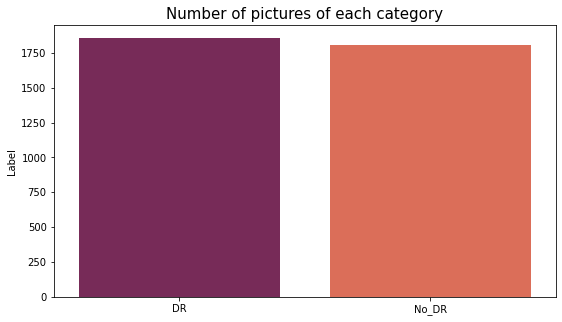

In [27]:
# Display the number of pictures of each category
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [28]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [29]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Epoch 1/10
93/93 [==============================] - 13s 120ms/step - loss: 0.2832 - accuracy: 0.8942 - val_loss: 0.1873 - val_accuracy: 0.9422
Epoch 2/10
93/93 [==============================] - 10s 107ms/step - loss: 0.1185 - accuracy: 0.9649 - val_loss: 0.1906 - val_accuracy: 0.9453
Epoch 3/10
93/93 [==============================] - 10s 106ms/step - loss: 0.1120 - accuracy: 0.9626 - val_loss: 0.1822 - val_accuracy: 0.9453
Epoch 4/10
93/93 [==============================] - 10s 104ms/step - loss: 0.1073 - accuracy: 0.9648 - val_loss: 0.1612 - val_accuracy: 0.9453
Epoch 5/10
93/93 [==============================] - 10s 105ms/step - loss: 0.0845 - accuracy: 0.9730 - val_loss: 0.1707 - val_accuracy: 0.9392
Epoch 6/10
93/93 [==============================] - 10s 109ms/step - loss: 0.0891 - accuracy: 0.9694 - v

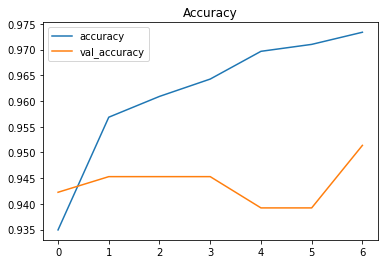

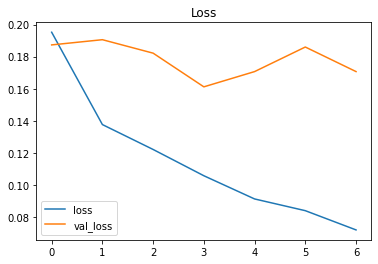

 ## Test Loss: 0.13433

## Accuracy on the test set: 95.37%



The first 5 predictions: ['DR', 'DR', 'No_DR', 'DR', 'No_DR']
              precision    recall  f1-score   support

          DR       0.96      0.94      0.95       177
       No_DR       0.95      0.96      0.96       190

    accuracy                           0.95       367
   macro avg       0.95      0.95      0.95       367
weighted avg       0.95      0.95      0.95       367



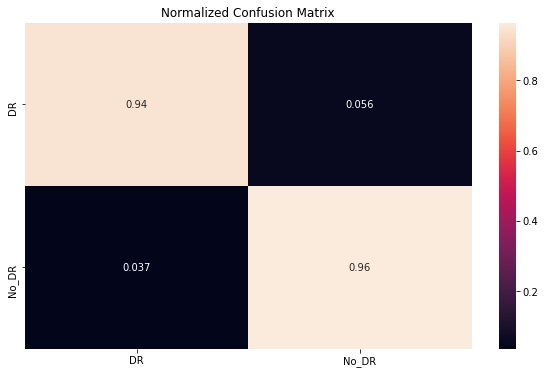

In [30]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

results = model.evaluate(test_images, verbose=0)

printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))
print('\n')

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()